In [186]:
!pip3 install pyro-ppl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [187]:
import arviz
#from numpyro.infer.util import Predictive

import os
import matplotlib.pyplot as plt
import torch
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn import datasets
from sklearn import model_selection

import pandas as pd
import pyro
import pyro.contrib.gp as gp
import pyro.infer.mcmc as HMC
import pyro.distributions as dist

from matplotlib.animation import FuncAnimation
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

smoke_test = "CI" in os.environ  # ignore; used to check code integrity in the Pyro repo

In [188]:
n = 1000
X = torch.linspace(-1.0, 1.0, n) 

def func(X):
  return np.sin(20*X) + 2*np.cos(14*X) - 2*np.sin(6*X)

In [189]:
x = torch.linspace(-1.0, 1.0, 5)
y = func(x)

In [190]:
kernel = gp.kernels.RBF(input_dim=1)
kernel.variance = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))

gpr = gp.models.GPRegression(x, y, kernel)

In [191]:
hmc_kernel=pyro.infer.NUTS(gpr.model, jit_compile=True)
mcmc = pyro.infer.MCMC(hmc_kernel, num_samples=500, num_chains=2, warmup_steps=500)
mcmc.run()
ls_name = "kernel.lengthscale"
posterior_ls = mcmc.get_samples()[ls_name]
vs_name = "kernel.variance"
posterior_vs = mcmc.get_samples()[vs_name]

/usr/local/lib/python3.8/dist-packages/pyro/infer/mcmc/api.py:497: UserWarning: num_chains=2 is more than available_cpu=1. Chains will be drawn sequentially.
  warnings.warn(
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1) != Z.size(1):
Warmup:   0%|          | 0/1000 [00:00, ?it/s]/usr/local/lib/python3.8/dist-packages/pyro/contrib/gp/kernels/isotropic.py:49: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if X.size(1)

pandas.core.frame.DataFrame

In [93]:
samples = mcmc.get_samples()

In [94]:
az_data = arviz.from_pyro(posterior=mcmc)
summary = arviz.summary(az_data)
summary

/usr/local/lib/python3.8/dist-packages/arviz/data/io_pyro.py:157: UserWarning: Could not get vectorized trace, log_likelihood group will be omitted. Check your model vectorization or set log_likelihood=False
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
kernel.lengthscale,5.850,16.006,0.002,24.093,0.676,0.478,615.0,590.0,1.0
kernel.variance,0.787,0.872,0.026,2.119,0.040,0.028,610.0,528.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0af7e892e0>,
      dtype=object)

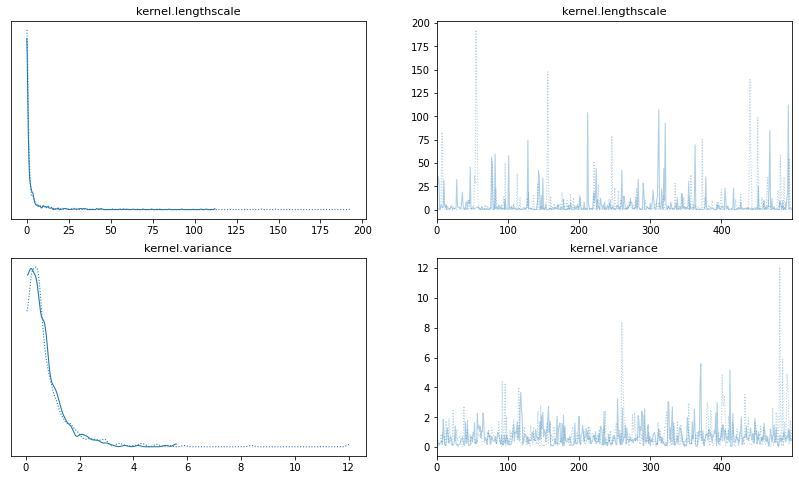

In [95]:
from numpy.core.fromnumeric import size
arviz.plot_trace(az_data, figsize=(14, 8))

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f0af7d676a0>,
      dtype=object)

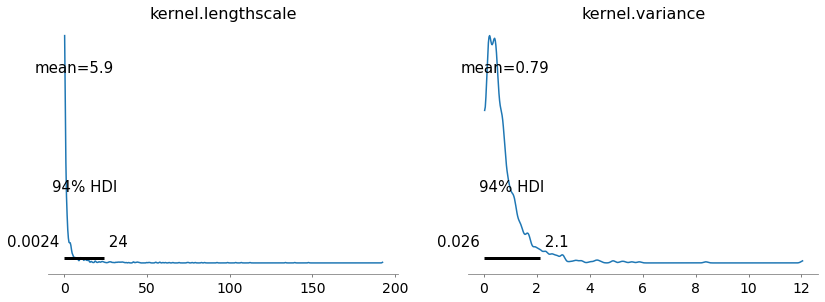

In [96]:
arviz.plot_posterior(az_data)

# Create log/log scatter plot of 500 samples from the posterior $p(θ|\mathcal{D})$

In [182]:
import random
idx = random.sample(range(1000), 500)
post_len = []
for i in idx:
  post_len.append(posterior_ls[i])

post_var = []
for i in idx:
  post_var.append(posterior_vs[i])

post_len = pd.DataFrame(post_len)
post_var = pd.DataFrame(post_var)
df = pd.concat([post_len.reset_index(drop=True), post_var], axis=1)
df.columns = ['length_scale', 'variance']

In [206]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
#plt.rcParams['text.usetex'] = True #enable Tex

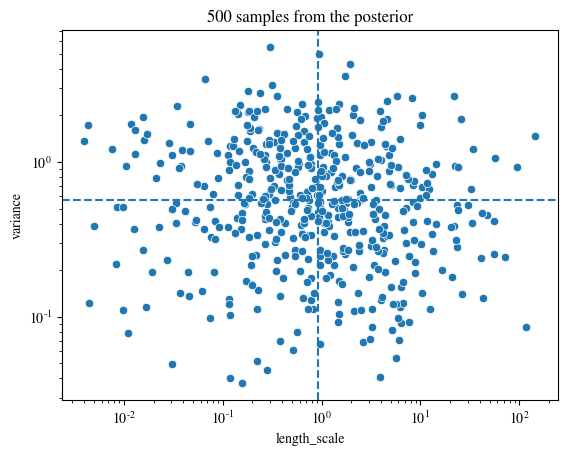

In [216]:
sns.scatterplot(data=df, x="length_scale", y="variance")
plt.xscale('log')
plt.yscale('log')
plt.title('500 samples from the posterior')
plt.axvline(df['length_scale'].median(), ls = '--')
plt.axhline(df['variance'].median(), ls = '--')

